#Setup

In [1]:
# !pip install fastai
from fastai import *
from fastai.vision import *
# from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image
from torchvision import transforms

In [2]:
import os
from pathlib import Path
import PIL.Image as PilImage

In [3]:
path=Path('data')
path.ls()

[PosixPath('data/bin_masks'),
 PosixPath('data/images_green'),
 PosixPath('data/labeled images'),
 PosixPath('data/Validation'),
 PosixPath('data/masks'),
 PosixPath('data/images_brown'),
 PosixPath('data/images_ndvi')]

In [4]:
path_lbl = path/'labeled images'
path_img = path/'images_ndvi'
path_bm=path/'bin_masks'
path_masks=path/'masks'

##Data

In [5]:
fnames=get_image_files(path_img)
lbl_names = get_image_files(path_masks)

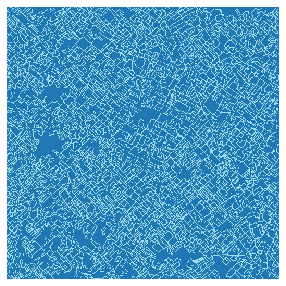

In [6]:
get_y_fn = lambda x: path_masks/f'{x.stem}{x.suffix}'
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(5,5), alpha=1)

In [7]:
# src_size = np.array(mask.shape[1:])
src_size=array([512,512])
src_size 

array([512, 512])

In [8]:
codes=np.array(['non-boundary','boundary'])

In [9]:
bs=3
size=src_size//2
# size=256
bs,size

(3, array([256, 256]))

In [10]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(0.2) 
        .label_from_func(get_y_fn,classes=codes))

In [11]:
data=   (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

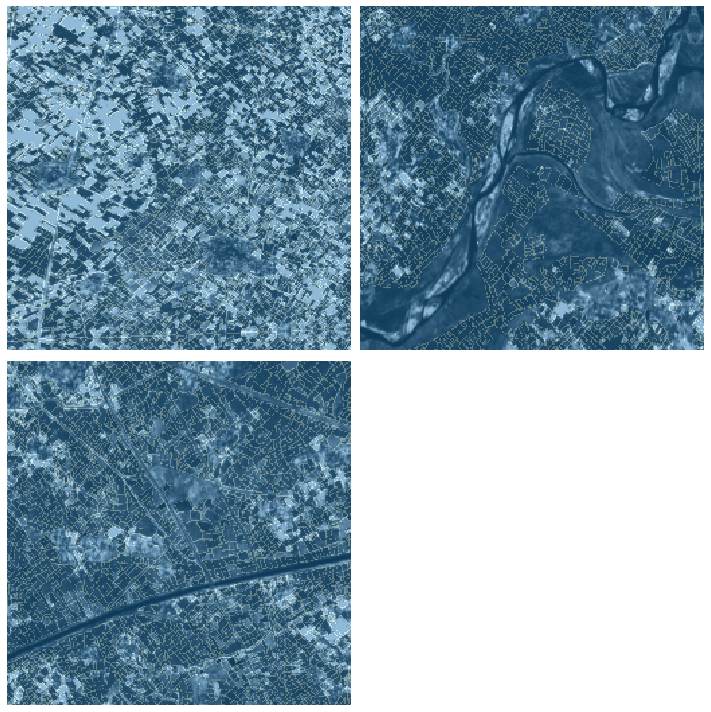

In [12]:
data.show_batch(2,figsize=(10,10))

In [13]:
def acc_camvid(input,target):
#     target = target.squeeze(1)
#     input.squeeze(1)
    return (input.data==target.data).float().mean()

In [14]:
metrics=acc_camvid


In [15]:
wd=1e-2

# Model: Resnet34
### For Resnet50, might have to change batch_size

In [16]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [17]:
learn.path=Path('')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


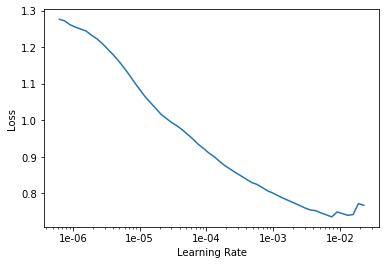

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr= 1e-3
learn.fit_one_cycle(15,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.838840,0.589803,0.000000,00:03
1,0.716015,0.579090,0.000000,00:01
2,0.668693,0.567822,0.000000,00:01
3,0.640004,0.576952,0.000000,00:01
4,0.621394,0.552607,0.000000,00:01
5,0.606596,0.548262,0.000000,00:01
6,0.596190,0.576592,0.000000,00:01
7,0.587855,0.537818,0.000000,00:01
8,0.580847,0.537345,0.000000,00:01
9,0.575507,0.541262,0.000000,00:01


In [20]:
learn.save('stage-1')

In [21]:
learn.load('stage-1');

In [22]:
learn.unfreeze()

In [23]:
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.532473,0.521661,0.000000,00:01
1,0.532631,0.523129,0.000000,00:01
2,0.531938,0.523081,0.000000,00:01
3,0.531059,0.520857,0.000000,00:01
4,0.531610,0.521862,0.000000,00:01
5,0.530113,0.524033,0.000000,00:01
6,0.530586,0.524435,0.000000,00:01
7,0.531039,0.527456,0.000000,00:01
8,0.531035,0.515683,0.000000,00:01
9,0.530888,0.520983,0.000000,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


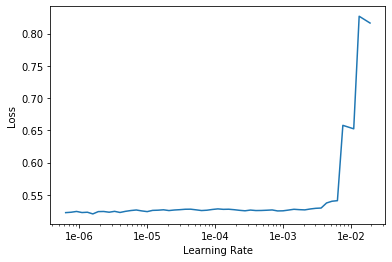

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
learn.save('stage-2')

In [26]:
learn.load('stage-2');

In [27]:
# lr_find(learn)
# learn.recorder.plot()

In [28]:
learn.destroy()
size=src_size
size

this Learner object self-destroyed - it still exists, but no longer usable


array([512, 512])

In [29]:
data=   (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [31]:
learn.path=Path('')

In [32]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


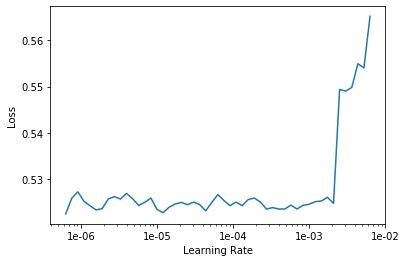

In [33]:
lr_find(learn)
learn.recorder.plot()

In [34]:
lr=3e-4
learn.fit_one_cycle(10,slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.525077,0.512992,0.000000,00:05
1,0.524107,0.509380,0.000000,00:02
2,0.524256,0.505854,0.000000,00:02
3,0.526124,0.512532,0.000000,00:02
4,0.526002,0.504259,0.000000,00:02
5,0.524554,0.502845,0.000000,00:02
6,0.524911,0.500603,0.000000,00:02
7,0.524260,0.516087,0.000000,00:02
8,0.523456,0.498653,0.000000,00:02
9,0.521862,0.498833,0.000000,00:02


In [35]:
learn.save('stage-1-big')

In [36]:
learn.load('stage-1-big');

In [37]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


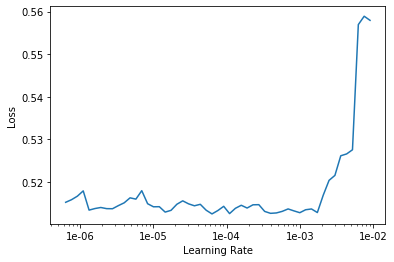

In [38]:
learn.recorder.plot()

In [39]:
lr=8e-5

In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(5, slice(lr),pct_start=0.6)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.510704,0.496852,0.000000,00:03
1,0.510583,0.495077,0.000000,00:02
2,0.513463,0.497251,0.000000,00:03
3,0.512285,0.493016,0.000000,00:02
4,0.512182,0.490932,0.000000,00:03


In [42]:
learn.save('stage-2-big')

In [43]:
learn.load('stage-2-big');

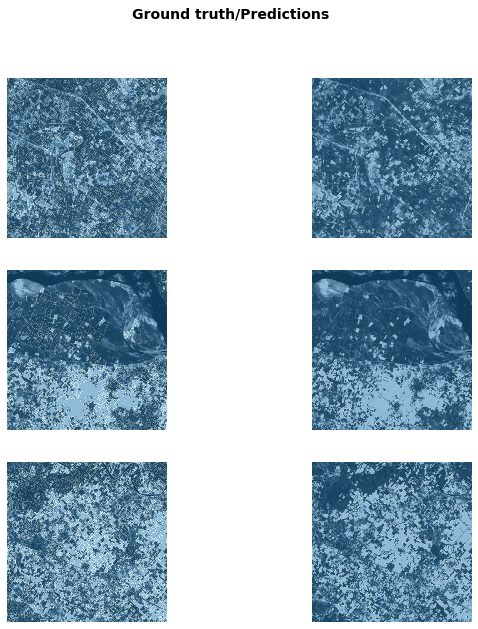

In [44]:
learn.show_results(rows=3, figsize=(10,10))

In [45]:
learn.destroy()
size=array([522,522])

this Learner object self-destroyed - it still exists, but no longer usable


In [46]:
data=   (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [47]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [48]:
learn.path=Path('')

In [49]:
learn.load('stage-2-big');

#Export

In [50]:
learn.export()

In [51]:
learn=load_learner('')

In [52]:
infer=sorted(get_image_files(path_img))

In [53]:
tgt=sorted(get_image_files(path_masks))

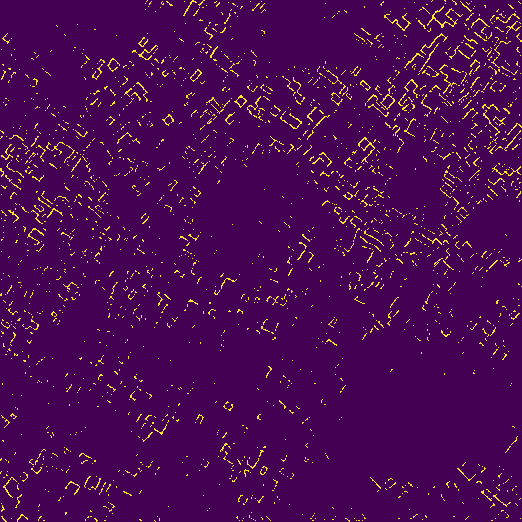

In [54]:
idx=8
img1=open_image(infer[idx])


a=learn.predict(img1)
a[0]

In [ ]:
#accuracy of the predictions
(a[0].data==open_image(tgt[idx]).data).float().mean()